## [Problem](https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview)

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost $335 and the other cost $9.99. Can you guess which one’s which?

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

Note that, because of the public nature of this data, this competition is a “Kernels Only” competition. In the second stage of the challenge, files will only be available through Kernels and you will not be able to modify your approach in response to new data. Read more details in the data tab and Kernels FAQ page. 


## Call libraries

In [1]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.2 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# 1.3 For plotting NN model

#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
from skimage import io
import pydot

# 1.4 Keras model components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 1.4.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer

# 1.4.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4.3 Import backend to invoke tensorflow commands to manipulate tensors
from tensorflow.keras import backend as K

# 1.5 Plotting libraries
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline 

# 1.6 Misc
import math, time, os,gc

In [2]:
# 1.7 Print all outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 1.8 Underestimate by 400
#     More penalized:

p = 600
a = 1000
(math.log(p) - math.log(a))**2


0.2609428178959133

In [4]:
# 1.9 Overestimate by 400

p =  1400
a = 1000
(math.log(p) - math.log(a))**2


0.11321356601688151

### Define rmsle()

In [5]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred)
    # 2.2 Get a list of squared differences of logs
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    # 2.3 Sum up all squared differences, take a mean and then square root 
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

## Mount gdrive

In [6]:
# 2.4
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Read data


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 3.1 Set path to train and test data
print("Loading data...")
path = "/gdrive/MyDrive/fa" 
#os.chdir(path)

Loading data...


In [9]:
# 3.1 Set path to train and test data
path = "/gdrive/MyDrive/fa"

In [11]:
# 3.2 Read datasets
%%time

print("---Loading data---")

train = pd.read_table("/content/drive/MyDrive/fa/train.tsv.zip")
test = pd.read_table("/content/drive/MyDrive/fa/test.tsv.zip")

print("---finished reading---")

---Loading data---
---finished reading---
CPU times: user 10.3 s, sys: 706 ms, total: 11 s
Wall time: 16.4 s


In [12]:
# 3.2.1
train.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [13]:
# 3.3 Print some information about datasets
#     In this data target is 'price'
print("---")
print(f"train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("---\n")

# 3.3.1
print(f"train Memory Usage : {sum(train.memory_usage())/10**6} MB")   # In MB
print(f"test Memory Usage : {sum(test.memory_usage())/10**6} MB")    # In MB
print("-----\n")

# 3.3.2
print(f"Train Null columns: {train.isnull().sum().sort_values()}")
print(f"Test Null columns: {train.isnull().sum().sort_values()}" )

---
train shape: (1482535, 8)
Test shape: (693359, 7)
---

train Memory Usage : 94.882368 MB
test Memory Usage : 38.828232 MB
-----

Train Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64
Test Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64


In [14]:
# 3.4 All columns but 'price' and shipping are categorical
train.dtypes
#test.dtypes
train.columns.values

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

array(['train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description'],
      dtype=object)

## Data pre-processing
>1. Missing values (three)<br>
>2. Label Encoding of categorical columns (three)<br>
>3. Transform fields having descriptive text to int sequences (two)<br>
>4. In each text field, find the length of int sequence with max  length<br>
>5. Scale numeric fields (1 + 1)<br>
>6. Create one random numeric field<br>

### Missing values
Fill missing values with constants


In [15]:
# 4.0 Fill missing values
#     Define a function to fill missing values
#     We use pandas methods df.fillna()
#     Fields: category_name, brand_name, item_description

def fill_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

In [16]:
# 4.1 Fill missing values now in train and test
train = fill_missing(train)
test = fill_missing(test)

In [17]:
# 4.2 Check if any value is still missing
train.isnull().sum()
test.isnull().sum()

# 4.3 Look at datasets now
train.head(3)
test.head(3)

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
dtype: int64

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


### Label Encoding of categorical data
Label encode `category_name` and `brand_name` fields

In [18]:
# 4.4 Label Encode categorical values
#     Two columns: category_name and brand_name

# 4.4.1 Look at train/test category_name data. Each is 1D array:
train.category_name.values.shape        # 1D (1482535,)
test.category_name.values.shape         # 1D (693359,)

(1482535,)

(693359,)

In [19]:
# 4.4.2 Merge 1D category_name data of train & test into one array:
catname_array = np.hstack([train.category_name.values, test.category_name.values])


# 4.4.3 Also merge brand_name data into one dimensional array
brname_array = np.hstack([train.brand_name.values, test.brand_name.values])

In [20]:
# 4.4.4 So final shapes:
catname_array.shape        # 1D array, (2175894,)
brname_array.shape         # 1D array, (2175894,)

# 4.4.5 And some values
catname_array[:3]
brname_array[:3]

(2175894,)

(2175894,)

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse'], dtype=object)

array(['missing', 'Razer', 'Target'], dtype=object)

In [21]:
# 5.0 Label or integer encode each category and brand name

# 5.1 Instantiate object for category name transformation
le = LabelEncoder()

# 5.2 Training first
le.fit(catname_array)

# 5.3 Next transformation
train.category_name = le.transform(train.category_name.values)
test.category_name = le.transform(test.category_name.values)

LabelEncoder()

In [22]:
# 5.4 Instantiate another object for brand name transformation
le = LabelEncoder()

# 5.5 fit and transform
le.fit(brname_array)
train.brand_name = le.transform(train.brand_name.values)
test.brand_name = le.transform(test.brand_name.values)

LabelEncoder()

In [23]:
# 5.6 How label encoder works:
#     Transforms alphabetically not by frequency
#     Coding starts from 0
a = ['zx', 'zx', 'az', 'bb', 'bb', 'bb']
le1 = LabelEncoder()
print(le1.fit_transform(a))

# 5.6.1
b = ['zx', 'zx','zx','zx', 'az', 'bb', 'bb', 'bb']
le2 = LabelEncoder()
print(le2.fit_transform(b))


[2 2 0 1 1 1]
[2 2 2 2 0 1 1 1]


In [24]:
# 5.7 Delete objects not needed
print(np.max(catname_array),np.max(brname_array))
del le, catname_array, brname_array
gc.collect()

missing wallis


309

In [25]:
# 5.8 Finally look at transformed data:

train.head(3)
test.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...


### Transform text fields to integer sequences
Takes time<br>
Fields are `item_description` and `name`. <br>
By default, `Tokenizer()` removes all punctuation, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They are then indexed.


In [26]:
# 6. Vectorize into integers text data
#    Two columns: item_description, name

# 6.1 We assume that words in 'item_description' and 'name'
#     columns are same or iterchangeable. This assumption
#     is made for simplification. Thst is, T-shirt, if
#     coded as 57 in item_decription' will also be coded 
#     as 57 in 'name' field.
#     (Correct approach would have been to treat the two fields separately)

# 6.2 Stack two columns, item_Description and name, as arrays, end-to-end in 1D array
#     We could also have stacked here: test.item_description.values, test.name.values

raw_text = np.hstack(
                     [
                       train.item_description.values,
                       train.name.values,
                       test.item_description.values,
                       test.name.values
                      ]
                     )



In [27]:
# 6.3 Train tokenizer
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#     Tokenizer filters punctuation, tabs and line-breaks
#
%%time

tok_raw = Tokenizer()           # Create Tokenizer() object
tok_raw.fit_on_texts(raw_text)  # Just training. No transformation as yet


CPU times: user 1min 34s, sys: 440 ms, total: 1min 35s
Wall time: 1min 35s


In [28]:
# 7. Transform 'item_description' to integer sequences
#    Our trained object tok_raw uses texts_to_sequences()
#    for the purpose:

# 7.1
print("Transforming of text to int seq for column, 'seq_item_desc'")
print("Transform train first to int sequences...")
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.values)
print("-----\n")
# 7.2
print("Transform test, next, to int sequences...")
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.values)
print("-----")

Transforming of text to int seq for column, 'seq_item_desc'
Transform train first to int sequences...
-----

Transform test, next, to int sequences...
-----


In [29]:



# 7.3 Check transformed data:

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098..."
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298..."


In [30]:
# 8.0 Similarly transform 'name' to integer sequences

# 8.1
print("Transforming of text to integer seq...for column, 'name'")
print("Transform train first..")
train["seq_name"] = tok_raw.texts_to_sequences(train.name.values)
print("-----\n")

# 8.2
print("Transform test next to integer seq..")
test["seq_name"] = tok_raw.texts_to_sequences(test.name.values)
print("Done... print Ist few rows. Check new columns seq_name")

Transforming of text to integer seq...for column, 'name'
Transform train first..
-----

Transform test next to integer seq..
Done... print Ist few rows. Check new columns seq_name


In [31]:
# 8.3 Look at data again:

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]"


#### **Problem**: In a pandas series of Integer sequences, find the highest integer. Simple: max of max:
seq_name<br>
[4,5,6]<br>
[10,34,1]<br>
[1,12,1]<br>
Answer: 34<br>

In [32]:
# 8.4 Here are data samples of transformed columns
train.seq_name[:10]

# 8.4.1 See below how max() behaves:
#       It prints that sequence which has the
#       maximum value:
print("\n\n---Seq having largest integer---\n")
print(train.seq_name[:10].max())

# 8.4.2 In that particular sequence,
#       fimd the maximum value:
print("\n--Highest ----\n")
print(np.max(train.seq_name[:10].max()))


0    [3878, 8988, 6978, 208, 84, 6, 155]
1            [11404, 27915, 17355, 2667]
2                     [7812, 10862, 666]
3                     [178, 2603, 14009]
4                 [4962, 103, 1032, 280]
5              [912, 85, 3582, 3, 93914]
6         [4845, 4896, 21493, 21865, 60]
7      [264, 3696, 1, 26513, 27, 11, 64]
8                    [264, 89, 501, 129]
9    [4051, 8980, 595, 11977, 181, 4806]
Name: seq_name, dtype: object



---Seq having largest integer---

[11404, 27915, 17355, 2667]

--Highest ----

27915


In [33]:
# 8.5 Here are data samples of seq_item_desc
train.seq_item_description[:10]

# 8.5.1 See below how max behaves:
print("\n\n---Seq having largest integer---\n")
print(train.seq_item_description[:10].max())


0                                         [12, 68, 79]
1    [29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...
2    [596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...
3    [5, 9, 61, 178, 6618, 229, 3, 21, 166, 1087, 2...
4                             [801, 9, 7025, 11, 2013]
5    [1320, 1722, 624, 5133, 327, 9, 778, 1967, 636...
6    [6, 44, 39, 468, 752, 15282, 8, 99, 179, 2829,...
7    [18, 145, 502, 351, 11, 9123, 3696, 129, 6, 44...
8                [264, 6, 44, 119, 148, 502, 129, 505]
9    [15, 3545, 1742, 181, 26, 14, 11440, 286, 2, 2...
Name: seq_item_description, dtype: object



---Seq having largest integer---

[1320, 1722, 624, 5133, 327, 9, 778, 1967, 6364, 54729, 625, 2357, 624, 1, 2889, 60]


#### Get max integer values now
This will give us an idea of vocabulary

In [34]:
# 9.0  Vocabulary sizes of all text-sequences and all label-encoded
#      caregories
#      This would be max integer value used in any column.
#      Because conversion to integer sequence starts from 1 


# 9.1 Columns seq_name and seq_item_description
MAX_TEXT_VOC = np.max([train.explode('seq_name')['seq_name'].max(),
                       test.explode('seq_name')['seq_name'].max(),
                       train.explode('seq_item_description')['seq_item_description'].max(),
                       test.explode('seq_item_description')['seq_item_description'].max(),
                      ]
                     ) + 2

print(f"Maximum Vocabulary size in seq_name is {MAX_TEXT_VOC}")


Maximum Vocabulary size in seq_name is 322001


In [35]:

# 9.2 Column category_name (transformed by label encoder)
MAX_CATEGORY_VOC = np.max(
                           [
                             train.category_name.max(),
                             test.category_name.max()
                           ]
                          ) + 1


print(f"Maximum Vocabulary size in category_name is {MAX_CATEGORY_VOC}")

Maximum Vocabulary size in category_name is 1311


In [36]:
# 9.3 Column brand_name (transformed by label encoder)
MAX_BRAND_VOC =   np.max([
                           train.brand_name.max(),
                           test.brand_name.max()
                         ]
                        ) + 1

print(f"Maximum Vocabulary size in brand_name is {MAX_BRAND_VOC}")


Maximum Vocabulary size in brand_name is 5290


In [37]:

# 9.4 Column, item_condition, already in integer format
MAX_CONDITION_VOC = np.max([
                            train.item_condition_id.max(),
                            test.item_condition_id.max()
                           ]
                          ) + 1

print(f"Maximum Vocabulary size in item_condition_id is {MAX_CONDITION_VOC} ")

Maximum Vocabulary size in item_condition_id is 6 


### **Problem:** Find length of int sequence having max length
In both the fields `seq_item_description` and in `seq_name` find the max length of sequences.

In [38]:
# 10.0 Behaviour of method: Series.max()
#     Create a sample one-column dataframe:

t = pd.DataFrame({'a' : [[2,2],[2,3],[3,5,2], [4,0],[3,10,1,1]]})
t

# Returns that row which has first value as maximum
#  When for two cases, 1st values are equal then IInd value is seen
#print(t.a.max())
print("\n")
print(t.explode('a').max())

,a
0,"[2, 2]"
1,"[2, 3]"
2,"[3, 5, 2]"
3,"[4, 0]"
4,"[3, 10, 1, 1]"




a    10.0
dtype: float64


In [39]:
# 10.1 Create another sample of one-column dataframe
#      but with different sequence lengths:

t = pd.DataFrame({'a' : [[2,2,3],[2,3,4,5],[3,5], [4,0,1,2,3,4],[3,10]]})
t
# 10.2 Returns that row which has maximum length

t.a.apply(lambda x: len(x))

print("\n=====")

print(np.max(t.a.apply(lambda x: len(x))))


,a
0,"[2, 2, 3]"
1,"[2, 3, 4, 5]"
2,"[3, 5]"
3,"[4, 0, 1, 2, 3, 4]"
4,"[3, 10]"


0    3
1    4
2    2
3    6
4    2
Name: a, dtype: int64


=====
6


In [40]:
# 11   Analysing sequence lengths of two columns
#     Two columns: item_description, name

# 11.1 Get maximum length integer sequences in column, seq_name
max_name_seq = np.max([
                       np.max(train.seq_name.apply(lambda x: len(x))),
                       np.max(test.seq_name.apply(lambda x: len(x)))
                       ]
                      )

# 11.2 Get maximum length of integer sequences in column, seq_item_description
max_seq_item_description = np.max([
                                   np.max(train.seq_item_description.apply(lambda x: len(x))),
                                   np.max(test.seq_item_description.apply(lambda x: len(x)))
                                   ]
                                  )

# 11.2.1
print(f"max name seq length: {max_name_seq}")
print(f"max item desc seq length: {max_seq_item_description}")

max name seq length: 17
max item desc seq length: 269


#### Histogram to look at distributions
Look at distribution of lengths of integer sequences

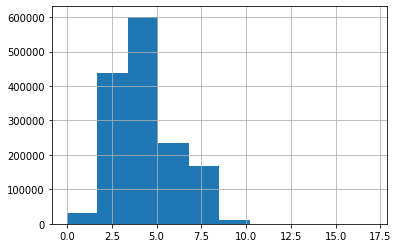

In [41]:
# 11.3 Get histogram of distribution of seq_name lengths
#      Histogram can be used to decide where to cut-off max lengths

train.seq_name.apply(lambda x: len(x)).hist()

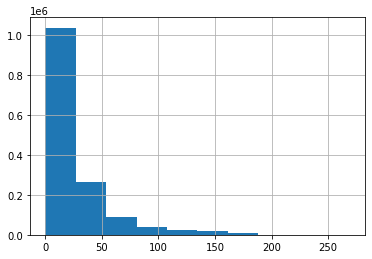

In [42]:
# 11.4 Get histogram of distribution of seq_item_description 
#      Histogram can be used to decide where to cut-off max lengths

train.seq_item_description.apply(lambda x: len(x)).hist()

In [43]:
# 12 EMBEDDINGS MAX VALUES
# 12.1 Based on the histograms, we select the max lengths
#      OR timesteps in RNN for two integer sequences, as:
#      Implication: Longer integer sequences will be truncated

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

## Numeric fields
Scale numeric field and create a random numeric field

### Scale 'price' field
>Take a log of 'price' to make it symmetrical  
>Scale the logged values using minmax scaler  
>Scaled price field is called 'target'

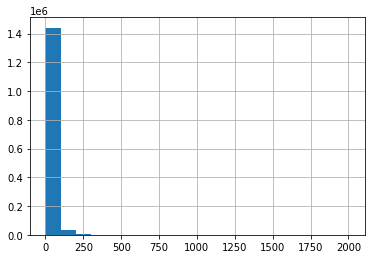

In [44]:
train.price.hist(bins=20)

In [45]:
# 13 Scale target variable, 'price': 
#     First take log and then scale log

# 13.1 First take a log of target. Why?
#      Make target values symmetric:

train["target"] = np.log( train.price + 1)   # Add 1 to escape from -ve infinity


In [46]:
# 13.2 Then scale log values using min-max scaler between -1 and 1
#      Why?
#      Scaling between (-1,1) is helpful in NN modeling
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c73dae590>]],
      dtype=object)

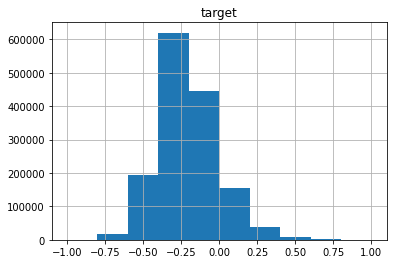

In [47]:
# 13.3 Display histogram of transformed target
#      It is quite symmetric
pd.DataFrame(train.target).hist()

### Create one more num column
This column will have random number values. The only numeric feature that we have is `'shipping'`. We will create one more  numerical column with random values for better demonstration of our proposed architecture. Otherwise, this column is NOT at all needed.


In [48]:
# 13.4 Create an arbitrary column. Why?
#      We want two numerical columns for better demonstration of our
#      proposed architecture. Otherwise, this column is NOT at all needed

# 13.5 Add some small random values to shipping column and create a new column
train['ship_rand'] = train.shipping + np.random.random(size = train.shipping[0])
train.head(3)

# 13.6
test['ship_rand'] = test.shipping + np.random.random(size = test.shipping[0])
#test.head(3)

# 13.7
train.shape    # (1482535, 12)
test.shape     # (693359, 10)   Missing 'price' and its transformed column 'target'


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]",-0.369464,1.209738
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]",0.044005,0.209738
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]",-0.369464,1.209738


(1482535, 12)

(693359, 10)

## Modeling--initial steps
>Split data<br>
>Expt with pad_sequences()<br>
>Define a function to create a dictionary of data

### Split data

In [49]:
# 18. Split into train and test
#     Note that we do not have 'y' here. 
#     Why? Because 'price' is a continuous variable

# 18.1 Just 'train' will be split into two parts
#      This is permissible in sklearn syntax
dtrain, dvalid = train_test_split(train,
                                  random_state=123,
                                  train_size=0.99    # 99% vs 1%
                                 )

print(dtrain.shape)     # (1467709, 12)
print(dvalid.shape)     # (14826, 12) 1% of above

(1467709, 12)
(14826, 12)


### Experiment with pad_sequences
Our dataset has:<br>
> 1. Categorical columns
>> Three integer columns: <b>item_condition_id</b>, <b>category_name</b> and <b>brand_name</b><br>
>> Two columns (of integer sequences): <b>seq_item_description</b> and <b>seq_name</b><br>

> 2. Numeric columns (two): <b>shipping, ship_rand</b><br>
> 3. Target column 'target'<br>

Thus total number of columns are: 3 +2 + 2+ 1 = 8


In [50]:
# 18.1.1 Just have a look at the train data:
dtrain.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
407853,407853,maroon velvet lisette shorts,1,1162,737,22.0,1,brand new from brandy melville,"[16, 5, 43, 537, 586]","[825, 1027, 17236, 129]",-0.175509,1.209738
748699,748699,Benefit Roller Lash Mascara FULL SIZE,2,26,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,"[1238, 2566, 1266, 641, 153, 6, 7, 2, 48, 24, ...","[1238, 2566, 1266, 641, 153, 6]",-0.287907,1.209738
320295,320295,Holographic Ipsy Bag,2,1303,5265,7.0,0,Used once,"[31, 96]","[2896, 2224, 101]",-0.453202,0.209738


Integer sequence columns `seq_item_description` and `seq_name` must have sequences of equal length. So we pad-sequences in each column. Here is what padding does.

In [51]:
# 18.2 Using keras pad_sequences function:
#      Example

print(f" Max size of sequence: {MAX_NAME_SEQ}")
print(f" Shape of dtrain.seq_name: {dtrain.seq_name.shape}")

s = pad_sequences(
                   dtrain.seq_name,
                   maxlen=MAX_NAME_SEQ
                  )

 Max size of sequence: 10
 Shape of dtrain.seq_name: (1467709,)


In [52]:
# 18.3 As 's' will be a numpy array
#       to observe it let us transform it
#        into pandas dataframe:

print(f"Shape of s: {s.shape}")

# 18.4 Here is dataframe:
pd.DataFrame(s).head(3)

Shape of s: (1467709, 10)


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,825,1027,17236,129
1,0,0,0,0,1238,2566,1266,641,153,6
2,0,0,0,0,0,0,0,2896,2224,101


### Define a function to create a dictionary of data
That is we are sort of transforming pandas dataframe to a dictionary as per our conveience


In [53]:
# 19.0 Define a function that creates a dictionary of array values 
#      to help to feed data into keras
#      All columns but the last 'num_vars' are categorical
#      WE have SIX columns or column-sets here
def get_keras_data(dataset):
    X = {   
        'name_in':           pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),                        # 1
        'item_desc_in':      pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),       # 2
        'brand_name_in':     np.array(dataset.brand_name),                                                # 3
        'category_name_in':  dataset.category_name.values,                                                # 4
        'item_condition_in': dataset.item_condition_id.values,                                            # 5
        'num_vars_in':       np.array(dataset[["shipping", "ship_rand"]])    # Two numeric columns here   # 6
    }
    return X


In [54]:
# 19.1 Get these datasets now
X_train = get_keras_data(dtrain)  # type: dict

In [55]:
X_train.keys()

dict_keys(['name_in', 'item_desc_in', 'brand_name_in', 'category_name_in', 'item_condition_in', 'num_vars_in'])

In [56]:
# 19.1.1 Observe X_train:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])



name_in  :  [[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]]


item_desc_in  :  [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     

In [57]:
# 19.1.2 Similarly for X_valid and X_test:

X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [58]:
# 19.2 As each dict item is a numpy array,
#      we can check shapes. We need these below:

print(X_train["name_in"][:4])
print("\n===========")
print(X_train["name_in"].shape)

[[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]
 [    0     0     0     0     0     0     0  2896  2224   101]
 [    0     0   444   433 12285    95    95  3956   244 11547]]

(1467709, 10)


In [59]:
# 19.3 Check more shapes.

print(X_train["item_desc_in"][:4])
print("\n\n===========")
print(X_train["item_desc_in"].shape)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     18    51   133    63   385    83   177   261    42   550   175     3
     35   191  1897]
 [    0     0     0     0     0     0     0     0     0     0     0   

In [60]:
# 19.4 Check more shapes. 

X_train["num_vars_in"][:4]
X_train["num_vars_in"].shape[1]       # 2

array([[1.        , 1.20973831],
       [1.        , 1.20973831],
       [0.        , 0.20973831],
       [1.        , 1.20973831]])

2

In [61]:
# 20.0 Define callback function for earlystopping and storing weights
#      May forget this in the first reading
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


In [62]:
# 20.1 Forget it in first reading. Another loss function
#      Any functions used in the model must use tensors
#      and not numpy arrays. Of course, dataset can be numpy
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

### Constants

In [63]:
# 21 Define sizes of categorical values AND word to vectors
#      Sizes?
word2vec_size = 50
cat2vec_size = 10
cond2vec_size = 5

In [64]:
X_train["name_in"].shape[1]
X_train["item_desc_in"].shape[1]

10

75

In [65]:
# 21.1 SIX Inputs. At each input specify number of input-features:

name =            Input(shape=[X_train["name_in"].shape[1]],      name="name_in")           # Length of each sequence
item_desc =       Input(shape=[X_train["item_desc_in"].shape[1]], name="item_desc_in")      # Length of each sequence
brand_name =      Input(shape=[1],                             name="brand_name_in")     # Just 1 feature. Hence shape=[1]
category_name =   Input(shape=[1],                             name="category_name_in")  # Just 1 feature. Hence shape=[1]
item_condition =  Input(shape=[1],                             name="item_condition_in") # Just 1 feature. Hence shape = [1]
num_vars =        Input(shape=[X_train["num_vars_in"].shape[1]],  name="num_vars_in")


### Embedding layers
In each *Embedding layer* specify the vocabulary size and word2vec size

In [66]:
# 21.2 FIVE Embeddings layers.  Embedding vectors of first FIVE of the above

# 21.3   Output of following two also go in RNN.
#        RNN output needs no flattening as this output is received
#        AFTER all timesteps have been fed into RNN
emb_name =           Embedding(MAX_TEXT_VOC,      word2vec_size  )(name)               
emb_item_desc =      Embedding(MAX_TEXT_VOC,      word2vec_size  )(item_desc)

# 21.3.1 Output of following three go directly into Dense layer after flattening
#        These need to be flattened as for every timestep there is a vector
emb_brand_name =     Embedding(MAX_BRAND_VOC,     cat2vec_size  )(brand_name)
emb_category_name =  Embedding(MAX_CATEGORY_VOC,  cat2vec_size  )(category_name)
emb_item_condition = Embedding(MAX_CONDITION_VOC, cond2vec_size )(item_condition)

### RNN layers
The above diagram also explains output of RNN (read GRU).

In [67]:
# 22 TWO RNN layers. Both these are independent of each other. 
rnn_layer2 = GRU(8) (emb_name)          # Output of GRU is a vector of size 8
rnn_layer1 = GRU(16) (emb_item_desc)    # Output of GRU is a vector of size 16

### Concatenation

In [68]:
# 23. Before we concatenate, let us see shape of 
#     each output tensor
print(f"emb_brand_name: {emb_brand_name.shape}")            # (None, 1, 10)
print(f"emb_category_name: {emb_category_name.shape}")      # (None, 1, 10)
print(f"emb_item_condition: {emb_item_condition.shape}")    # (None, 1, 5)
print(f"rnn_layer1: {rnn_layer1.shape}")                    # (None, 16)
print(f"rnn_layer1: {rnn_layer2.shape}")                    # (None, 8)


emb_brand_name: (None, 1, 10)
emb_category_name: (None, 1, 10)
emb_item_condition: (None, 1, 5)
rnn_layer1: (None, 16)
rnn_layer1: (None, 8)


In [69]:
# 23.1 Concatenate all layer-branches 
main_l = concatenate(
                        [
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                        ]
                      )

### Classification layer

In [70]:
# 24.0 Level of dropouts: 10%
dr_r = 0.1   

# 24.1 Add classification layer
main_l = Dense(128) (main_l)
main_l = Dropout(dr_r)(main_l)
main_l = Dense(64) (main_l)
main_l = Dropout(dr_r) (main_l)

### Output node

In [71]:
# 24.2 Output neuron
output = Dense(1, activation="linear") (main_l)

### Define model and compile

In [72]:
# 25 Formulate Model now
model = Model(
              inputs= [                     
                        name,
                        item_desc,
                        brand_name,
                        category_name,
                        item_condition,
                        num_vars
                       ],
              outputs= output
              )



In [73]:
# 25.1
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]    # Not using rmsle_cust
              )

### Model summary and plot

In [74]:
# 26 Formulate model and show summary    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name_in (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 category_name_in (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 item_condition_in (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 item_desc_in (InputLayer)      [(None, 75)]         0           []                               
                                                                                              

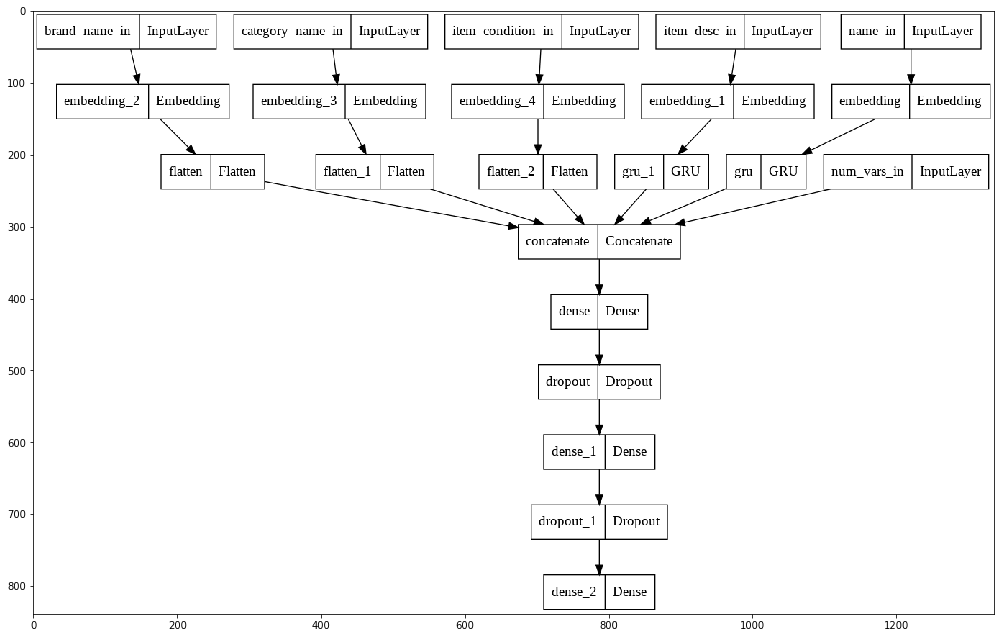

In [75]:
# 26.1 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model, to_file = "model.png");
io.imshow("model.png");

### Fit model

In [76]:
# 26.2. Some constants
BATCH_SIZE = 20000
epochs = 5

In [77]:
# 26.3 Observe our training data once more:
#      Note that X_train is a dictionary of arrays:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])



name_in  :  [[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]]


item_desc_in  :  [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     

In [78]:
# 26.4

start = time.time()
history= model.fit(X_train,
                   dtrain.target,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   validation_data=(X_valid, dvalid.target),
                   verbose=1
                  )

end = time.time()
print((end-start)/60)    # Five epochs take 15 minutes. Per epoch 240 secs

Epoch 1/5
74/74 [==============================] - 245s 3s/step - loss: 0.0347 - mae: 0.1415 - val_loss: 0.0191 - val_mae: 0.1050
Epoch 2/5
74/74 [==============================] - 235s 3s/step - loss: 0.0198 - mae: 0.1070 - val_loss: 0.0165 - val_mae: 0.0973
Epoch 3/5
74/74 [==============================] - 235s 3s/step - loss: 0.0169 - mae: 0.0986 - val_loss: 0.0156 - val_mae: 0.0945
Epoch 4/5
74/74 [==============================] - 235s 3s/step - loss: 0.0154 - mae: 0.0940 - val_loss: 0.0153 - val_mae: 0.0941
Epoch 5/5
74/74 [==============================] - 238s 3s/step - loss: 0.0146 - mae: 0.0914 - val_loss: 0.0153 - val_mae: 0.0935
20.44251397450765


## Evaluation


In [79]:
# 27 Evaluate model using validation data
val_preds = model.predict(X_valid)

In [80]:
# 27.1 Undo transformation by MinMaxScaler

val_preds = target_scaler.inverse_transform(val_preds)  

In [81]:
# 27.2 Undo logs:

val_preds = np.exp(val_preds) - 1   # It should be -1. Original code has +1
print(val_preds[:10])     # (10,1)

print(val_preds[:10, 0])  # Convert to 1D
y_pred = val_preds[:,0]

[[40.05217 ]
 [11.793141]
 [25.48936 ]
 [15.912708]
 [37.239853]
 [13.177496]
 [17.876062]
 [30.006006]
 [25.472042]
 [22.148905]]
[40.05217  11.793141 25.48936  15.912708 37.239853 13.177496 17.876062
 30.006006 25.472042 22.148905]


In [82]:
# 27.3 Mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_true[:10]

# 27.4
v_rmsle = rmsle(y_true, y_pred)
print("\n RMSLE error on dev test: "+str(v_rmsle))

array([31., 15., 26., 16., 50.,  7., 23., 23., 60., 16.])


 RMSLE error on dev test: 0.4699601835836483


In [83]:

# 20. Create Predictions on test data
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

# 20.1
submission = test[["test_id"]]
submission["price"] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


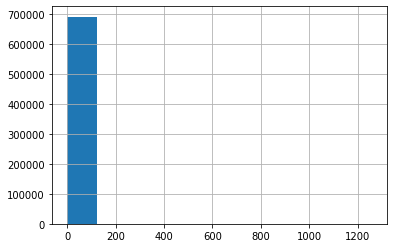

In [84]:
# 20.2 Should you want to submit on 
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()
